In [3]:
# à mettre dans le terminal
# pip install gdown
# gdown https://drive.google.com/uc?id=1PkZYDUtgH-dRBPssB1U6OzQBikV6mVCb

import pandas as pd


# Lecture des 5 premières lignes du fichier
df = pd.read_csv("list_cpc_patent_EP.csv", nrows=10)
print(df)
# la table des brevets contient 29 779 374 lignes

df = pd.read_csv("list_cpc_patent_EP.csv")
#on compte le nb de lignes dans la table
n_avant = len(df)

# Étape 1 : on supprime les doublons exacts (si même brevet + même CPC apparaissent plusieurs fois)
df_unique = df.drop_duplicates(subset=["publication_number", "CPC4"])

n_apres = len(df_unique)
nb_doublons = n_avant - n_apres

print(f"Nombre de lignes avant suppression des doublons : {n_avant}")
print(f"Nombre de lignes après suppression des doublons  : {n_apres}")
print(f"Nombre de doublons supprimés                     : {nb_doublons}")

# Nombre de lignes avant suppression des doublons : 29 779 373
# Nombre de lignes après suppression des doublons  : 5 401 265
# Nombre de doublons supprimés                     : 24 378 108
# Nombre de brevets avec plusieurs CPC : 1524689

#  Étape 2 : on compte le nombre de codes CPC distincts par brevet
cpc_counts = df_unique.groupby("publication_number")["CPC4"].nunique().reset_index(name="nb_cpc")

# Étape 3 : on filtre les brevets avec plusieurs codes CPC
multi_cpc = cpc_counts[cpc_counts["nb_cpc"] > 1]

# Étape 4 : on fait une jointure pour voir le détail des codes CPC correspondants
multi_cpc_details = df_unique[df_unique["publication_number"].isin(multi_cpc["publication_number"])]

# afficher un aperçu
print("Nombre de brevets avec plusieurs CPC :", multi_cpc.shape[0])
print(multi_cpc_details.head(10))
# Nombre de brevets avec plusieurs CPC : 1 524 689

# On regroupe les codes CPC par brevet sous forme de liste
cpc_list = (
    df_unique
    .groupby("publication_number")["CPC4"]
    .apply(list)
    .reset_index(name="liste_CPC")
)

# On garde uniquement les brevets avec plusieurs CPC
multi_cpc_list = cpc_list[cpc_list["liste_CPC"].apply(lambda x: len(x) > 1)]

print("Nombre de brevets avec plusieurs CPC :", multi_cpc_list.shape[0])
print(multi_cpc_list.head(10))
multi_cpc_list.to_csv("brevets_multicpc.csv", index=False)


df_multi_cpc = pd.read_csv("brevets_multicpc.csv", nrows=20)
print(df_multi_cpc)
n_multi = len(df_multi_cpc)
print(n_multi)

filename = "brevets_multicpc.csv"

with open(filename, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f) - 1  # on enlève 1 pour l'en-tête

print(f"Nombre de brevets multiclassés : {n_lines}")

# Nombre de brevets multiclassés : 1 524 689


# Analyse statistique de la répartition des sections parmi les brevets

# On part de df_unique qui contient les brevets uniques par (publication_number, CPC4)

# 1. Extraire la section (première lettre du code CPC4)
df_unique["section"] = df_unique["CPC4"].str[0]

# 2. Compter le nombre de brevets par section
counts = df_unique["section"].value_counts().sort_index()

# 3. Calculer le pourcentage
percentages = 100 * counts / counts.sum()

# 4. Afficher le résultat
result = pd.DataFrame({"count": counts, "percentage": percentages})
print(result)



  publication_number  publication_date  CPC4
0      EP-0021337-B1          19831207  A61K
1      EP-0025814-B1          19840502  A61F
2      EP-0259538-B1          19901227  G01D
3      EP-0011162-B1          19811021  Y10S
4      EP-0125128-B1          19870826  G03G
5      EP-0149008-B1          19880224  Y10T
6      EP-4216614-B1          20241211  H04W
7      EP-4225729-B1          20240731  A61K
8      EP-3637353-B1          20240410  G06F
9      EP-3678885-B1          20220105  B60W
Nombre de lignes avant suppression des doublons : 29779373
Nombre de lignes après suppression des doublons  : 5401265
Nombre de doublons supprimés                     : 24378108
Nombre de brevets avec plusieurs CPC : 1524689
   publication_number  publication_date  CPC4
2       EP-0259538-B1          19901227  G01D
3       EP-0011162-B1          19811021  Y10S
4       EP-0125128-B1          19870826  G03G
5       EP-0149008-B1          19880224  Y10T
6       EP-4216614-B1          20241211  H04W
7   

/tmp/ipykernel_16333/2630909577.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["section"] = df_unique["CPC4"].str[0]


          count  percentage
section                    
A        773814   14.326533
B        980117   18.146064
C        806741   14.936149
D         83078    1.538121
E        139324    2.579470
F        529558    9.804333
G        745701   13.806044
H        849423   15.726372
Y        493509    9.136915


In [ ]:


# graphes


import matplotlib.pyplot as plt


# Graphique en camembert
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Répartition des sections CPC (camembert)")
plt.axis("equal")  # Pour que le cercle soit rond
plt.show()

# Histogramme 
plt.figure(figsize=(10, 6))
counts.plot(kind="bar", color="skyblue")
plt.title("Nombre de brevets par section CPC")
plt.xlabel("Section CPC")
plt.ylabel("Nombre de brevets")
plt.xticks(rotation=0)
plt.show()



In [4]:

# Analyse des combinaisons fréquentes de codes CPC à partir de brevets_multicpc.csv

import ast

# On charge le fichier
df = pd.read_csv("brevets_multicpc.csv")

# La colonne liste_CPC est en format string (ex : "['A61K', 'A61P', 'C07D']")
# On la convertit en liste Python
df['liste_CPC'] = df['liste_CPC'].apply(ast.literal_eval)

print(df.head())

# Pour commencer, on peut extraire la classe CPC (lettre + 2 chiffres) pour réduire la granularité :
def extract_classe(cpc_code):
    # Exemple: 'A61K' -> 'A61', 'G06F' -> 'G06'
    return cpc_code[:3]

df['liste_classes'] = df['liste_CPC'].apply(lambda codes: list(set(extract_classe(c) for c in codes)))

print(df[['liste_CPC', 'liste_classes']].head())

# Construction de la matrice d’occurrence des classes CPC
# On veut savoir quelles classes apparaissent souvent ensemble.
# Pour cela, on va : 
# 1) lister toutes les classes distinctes
# 2) pour chaque brevet, noter la présence ou absence de chaque classe
# construire une matrice binaire (brevet x classe)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['liste_classes'])

df_matrix = pd.DataFrame(X, columns=mlb.classes_)

print(df_matrix.head())

# Calcul de la matrice de co-occurrence
# La matrice de co-occurrence est une matrice carrée où l’élément (i,j) indique
#  combien de brevets ont à la fois la classe i et la classe j
cooccurrence = df_matrix.T.dot(df_matrix)

print(cooccurrence)

# on identifie les associations fréquentes
# Les valeurs diagonales indiquent le nombre de brevets contenant chaque classe.
# Les valeurs hors diagonale indiquent le nombre de brevets contenant les deux classes ensemble.
# On peut par exemple extraire les paires (i,j) avec un seuil minimal pour repérer les associations fortes :

threshold = 1000  # Ajuste ce seuil selon la taille de ta base

cooccurrence_pairs = []

for i, classe_i in enumerate(cooccurrence.index):
    for j, classe_j in enumerate(cooccurrence.columns):
        if i < j:  # pour ne pas doubler les paires (i,j) et (j,i)
            val = cooccurrence.iloc[i,j]
            if val >= threshold:
                cooccurrence_pairs.append((classe_i, classe_j, val))

# Trier par co-occurrence décroissante
cooccurrence_pairs = sorted(cooccurrence_pairs, key=lambda x: x[2], reverse=True)

# Afficher les 10 premières associations fréquentes
print("Top 10 des associations fréquentes de classes CPC :")
for c1, c2, val in cooccurrence_pairs[:10]:
    print(f"{c1} & {c2} : {val} brevets")




  publication_number                                          liste_CPC
0      EP-0000001-B1  [C07C, B60L, F25B, A99Z, F24S, F28D, C08L, A61...
1      EP-0000002-B1                                 [C07D, A01N, F01D]
2      EP-0000004-B1                                       [B04B, A47J]
3      EP-0000005-B1                                       [C07D, A61P]
4      EP-0000006-B1                                       [C02F, Y02W]
                                           liste_CPC  \
0  [C07C, B60L, F25B, A99Z, F24S, F28D, C08L, A61...   
1                                 [C07D, A01N, F01D]   
2                                       [B04B, A47J]   
3                                       [C07D, A61P]   
4                                       [C02F, Y02W]   

                              liste_classes  
0  [F24, B60, C07, F28, F25, C08, A99, A61]  
1                           [F01, C07, A01]  
2                                [B04, A47]  
3                                [C07, A61]  
4

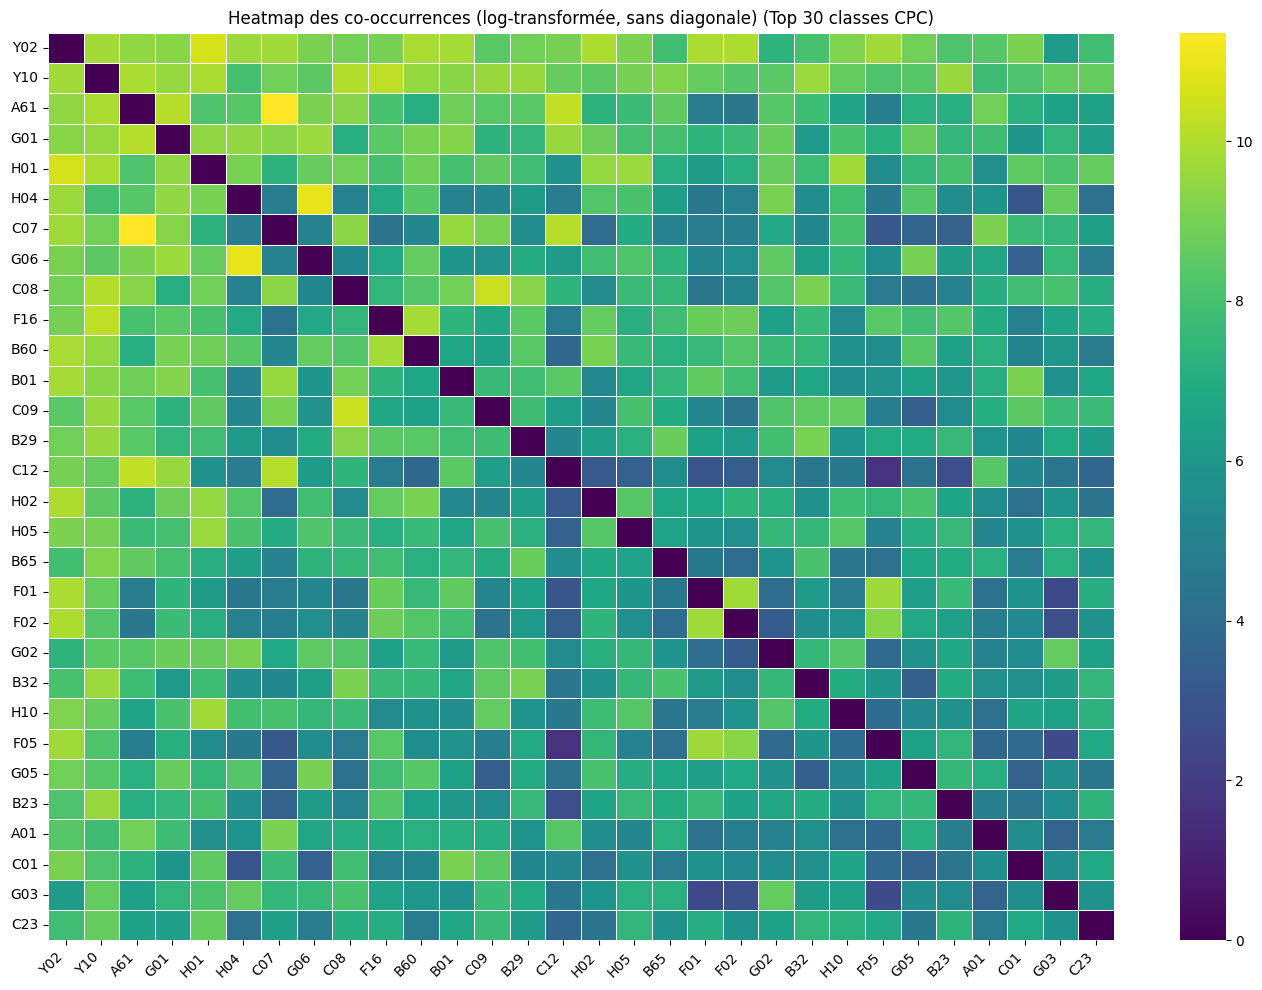

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cooc_no_diag = cooc_top.copy()
np.fill_diagonal(cooc_no_diag.values, 0)

cooc_log = np.log1p(cooc_no_diag)

plt.figure(figsize=(14, 10))
sns.heatmap(cooc_log, cmap="viridis", linewidths=0.5)
plt.title(f"Heatmap des co-occurrences (log-transformée, sans diagonale) (Top {N} classes CPC)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


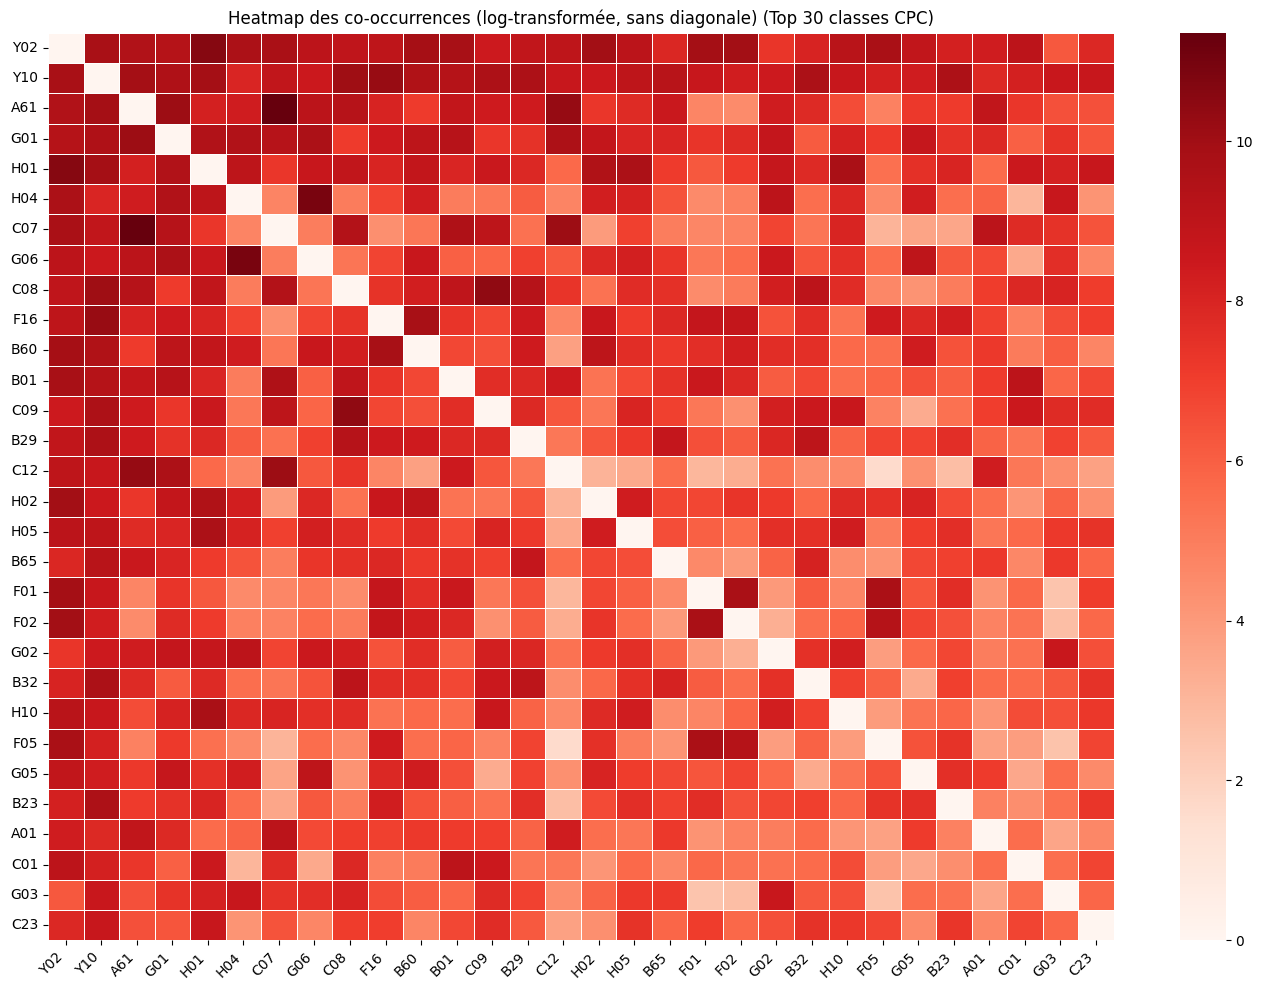

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(cooc_log, cmap="Reds", linewidths=0.5)
plt.title(f"Heatmap des co-occurrences (log-transformée, sans diagonale) (Top {N} classes CPC)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# CALCUL DU SCORE D'ORIGINALITÉ

cooc = cooccurrence.copy().astype(float)

# Marges
row_sum = cooc.sum(axis=1)
col_sum = cooc.sum(axis=0)
N = cooc.values.sum()

# Matrice des co-occurrences attendues
expected = np.outer(row_sum, col_sum) / N
expected = pd.DataFrame(expected, index=cooc.index, columns=cooc.columns)

# Pour éviter les 0 → on met un epsilon
epsilon = 1e-9
expected = expected.replace(0, epsilon)

# Score d'originalité
originality = cooc / expected

print(originality.head())

# Cette matrice indique si les couples sont plus fréquents que prévu ( > 1 ) ou moins fréquents ( < 1 ).


           A01         A21         A22        A23         A24       A41  \
A01  42.102876    0.319672    2.088806   2.388823    0.270519  0.320166   
A21   0.319672  430.597416   12.154714  35.720634    0.174222  0.000000   
A22   2.088806   12.154714  892.517950  15.636483    0.000000  0.442350   
A23   2.388823   35.720634   15.636483  66.925282    2.111881  0.032825   
A24   0.270519    0.174222    0.000000   2.111881  306.039673  0.000000   

          A42       A43       A44       A45  ...  G99       H01       H02  \
A01  0.291803  0.117336  0.395067  0.768537  ...  0.0  0.083462  0.160825   
A21  0.000000  0.000000  0.000000  0.000000  ...  0.0  0.011862  0.019807   
A22  0.000000  0.000000  0.205886  0.742419  ...  0.0  0.039896  0.063444   
A23  0.053601  0.015675  0.015278  0.055091  ...  0.0  0.025375  0.015065   
A24  0.000000  0.072668  0.212479  0.681063  ...  0.0  0.496041  1.353160   

          H03       H04       H05       H10       Y02       Y04       Y10  
A01  0.052

In [ ]:
# INDICE DE CONVERGENCE PAR ENTROPIE

# On vectorise les valeurs hors-diagonale
vals = cooc.values
triu_idx = np.triu_indices_from(vals, k=1)
v = vals[triu_idx]

# Probas
p = v / v.sum()

# Entropie de Shannon
entropy = -np.sum(p * np.log(p + epsilon))

# Normalisation (max entropy = log(nb_paires))
max_entropy = np.log(len(p))

ICT_entropy = entropy / max_entropy

print("Indice ICT (entropie normalisée) :", ICT_entropy)

# Un indice entre 0 et 1 : 0 = technologies cloisonnées / 1 = recombinaisons très diversifiées


Indice ICT (entropie normalisée) : 0.7509047879159031
